# Clustering Stocks

## Import libraries

In [21]:
# Data
import yfinance as yf

# Processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from chardet.universaldetector import UniversalDetector

# Modeling
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import silhouette_samples, silhouette_score

# Graphics
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Load Dataset

### IBOV stocks list

In [2]:
detector = UniversalDetector()

# Substitua 'seu_arquivo.csv' pelo nome do seu arquivo CSV
with open('dataset/IBOVDia_23-11-23.csv', 'rb') as file:
    for line in file:
        detector.feed(line)
        if detector.done:
            break
    detector.close()

encoding = detector.result['encoding']

# Use a codificação detectada para ler o arquivo CSV
ibov_stocks_list = pd.read_csv('dataset/IBOVDia_23-11-23.csv', sep=';', skiprows=1, skipfooter=2, encoding=encoding, engine='python')
ibov_stocks_list

,Código,Ação,Tipo,Qtde. Teórica,Part. (%)
0,RRRP3,3R PETROLEUM,ON NM,235.661.666,"0,351"
1,ALOS3,ALLOS,ON NM,532.616.595,"0,611"
2,ALPA4,ALPARGATAS,PN ATZ N1,208.965.950,"0,090"
3,ABEV3,AMBEV S/A,ON,4.394.245.879,"2,735"
4,ARZZ3,AREZZO CO,ON EDJ NM,62.305.891,"0,174"
...,...,...,...,...,...
81,VALE3,VALE,ON EDJ NM,4.427.123.466,"15,201"
82,VAMO3,VAMOS,ON NM,421.383.330,"0,188"
83,VBBR3,VIBRA,ON NM,1.114.412.532,"1,124"
84,WEGE3,WEG,ON NM,1.481.593.024,"2,318"


### IBOV stocks historical data

In [3]:
ibov_stocks_list['Código'] = ibov_stocks_list['Código'].apply(lambda x: x + '.SA')
ibov_stocks_list

,Código,Ação,Tipo,Qtde. Teórica,Part. (%)
0,RRRP3.SA,3R PETROLEUM,ON NM,235.661.666,"0,351"
1,ALOS3.SA,ALLOS,ON NM,532.616.595,"0,611"
2,ALPA4.SA,ALPARGATAS,PN ATZ N1,208.965.950,"0,090"
3,ABEV3.SA,AMBEV S/A,ON,4.394.245.879,"2,735"
4,ARZZ3.SA,AREZZO CO,ON EDJ NM,62.305.891,"0,174"
...,...,...,...,...,...
81,VALE3.SA,VALE,ON EDJ NM,4.427.123.466,"15,201"
82,VAMO3.SA,VAMOS,ON NM,421.383.330,"0,188"
83,VBBR3.SA,VIBRA,ON NM,1.114.412.532,"1,124"
84,WEGE3.SA,WEG,ON NM,1.481.593.024,"2,318"


In [4]:
ibov_stocks_historical_data = pd.DataFrame()
for ticker in ibov_stocks_list['Código']:
    try:
        stock = yf.download(ticker, start='2019-01-01', end='2019-12-31', progress=False)['Close']
        ibov_stocks_historical_data = pd.concat([ibov_stocks_historical_data, stock], axis=1)
    except:
        print('Ação' + ticker + 'não localizada')


1 Failed download:
['RRRP3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

1 Failed download:
['ALOS3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

1 Failed download:
['ASAI3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

1 Failed download:
['CMIN3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

1 Failed download:
['SOMA3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

1 Failed download:
['IGTI11.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

1 Failed download:
['LWSA3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

1 Failed download:
['RECV3.SA']: Exception("%ticker%: Data doesn't exist for startDate = 1546308000, endDate = 1577761200")

In [5]:
ibov_stocks_historical_data

,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
2019-01-02,NaN,NaN,14.000000,16.150000,55.310001,NaN,36.330002,9.263333,28.320000,22.395441,...,41.910000,12.15,9.531889,27.170000,9.76,51.090000,NaN,26.000000,8.990000,24.850000
2019-01-03,NaN,NaN,14.024000,16.330000,55.580002,NaN,36.369999,9.666666,28.629999,22.852491,...,41.400002,11.92,9.751472,26.665001,9.55,49.000000,NaN,26.600000,9.195000,24.830000
2019-01-04,NaN,NaN,13.920000,16.549999,53.330002,NaN,36.250000,9.316666,28.350000,22.351616,...,41.090000,11.98,10.020960,26.485001,10.11,52.189999,NaN,26.700001,9.300000,25.209999
2019-01-07,NaN,NaN,13.888000,16.480000,52.529999,NaN,35.299999,9.266666,27.930000,22.539444,...,41.200001,12.37,9.804704,25.674999,10.13,51.910000,NaN,26.850000,9.155000,24.709999
2019-01-08,NaN,NaN,14.160000,16.150000,54.049999,NaN,34.720001,9.293333,27.520000,22.789883,...,40.299999,12.84,9.405462,25.250000,9.77,52.410000,NaN,25.950001,9.080000,24.940001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,NaN,NaN,32.349998,18.910000,64.739998,NaN,57.000000,16.366667,37.740002,25.033810,...,48.849998,15.28,22.820000,24.610001,9.33,54.790001,NaN,29.299999,16.945000,48.119999
2019-12-23,NaN,NaN,32.700001,18.959999,65.800003,NaN,57.599998,15.623333,37.950001,25.537189,...,49.000000,15.39,22.556665,25.330000,9.53,54.580002,NaN,30.200001,16.895000,49.000000
2019-12-26,NaN,NaN,32.860001,19.219999,64.769997,NaN,57.070000,15.550000,37.759998,25.807663,...,49.889999,15.59,22.330000,25.600000,9.53,54.790001,NaN,30.139999,17.424999,48.599998
2019-12-27,NaN,NaN,32.660000,19.160000,63.980000,NaN,57.799999,14.736666,37.840000,25.642374,...,49.330002,15.59,21.606667,25.719999,9.43,53.599998,NaN,30.430000,17.670000,48.799999


In [6]:
ibov_stocks_historical_data.index

Index([2019-01-02 00:00:00, 2019-01-03 00:00:00, 2019-01-04 00:00:00,
       2019-01-07 00:00:00, 2019-01-08 00:00:00, 2019-01-09 00:00:00,
       2019-01-10 00:00:00, 2019-01-11 00:00:00, 2019-01-14 00:00:00,
       2019-01-15 00:00:00,
       ...
       2019-12-13 00:00:00, 2019-12-16 00:00:00, 2019-12-17 00:00:00,
       2019-12-18 00:00:00, 2019-12-19 00:00:00, 2019-12-20 00:00:00,
       2019-12-23 00:00:00, 2019-12-26 00:00:00, 2019-12-27 00:00:00,
       2019-12-30 00:00:00],
      dtype='object', length=248)

In [7]:
ibov_stocks_historical_data.columns = ibov_stocks_list['Ação']
ibov_stocks_historical_data.columns.name = None
ibov_stocks_historical_data.index.name = 'date'

In [8]:
ibov_stocks_historical_data

,3R PETROLEUM,ALLOS,ALPARGATAS,AMBEV S/A,AREZZO CO,ASSAI,AZUL,B3,BBSEGURIDADE,BRADESCO,...,TELEF BRASIL,TIM,TOTVS,ULTRAPAR,USIMINAS,VALE,VAMOS,VIBRA,WEG,YDUQS PART
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,14.000000,16.150000,55.310001,NaN,36.330002,9.263333,28.320000,22.395441,...,41.910000,12.15,9.531889,27.170000,9.76,51.090000,NaN,26.000000,8.990000,24.850000
2019-01-03,NaN,NaN,14.024000,16.330000,55.580002,NaN,36.369999,9.666666,28.629999,22.852491,...,41.400002,11.92,9.751472,26.665001,9.55,49.000000,NaN,26.600000,9.195000,24.830000
2019-01-04,NaN,NaN,13.920000,16.549999,53.330002,NaN,36.250000,9.316666,28.350000,22.351616,...,41.090000,11.98,10.020960,26.485001,10.11,52.189999,NaN,26.700001,9.300000,25.209999
2019-01-07,NaN,NaN,13.888000,16.480000,52.529999,NaN,35.299999,9.266666,27.930000,22.539444,...,41.200001,12.37,9.804704,25.674999,10.13,51.910000,NaN,26.850000,9.155000,24.709999
2019-01-08,NaN,NaN,14.160000,16.150000,54.049999,NaN,34.720001,9.293333,27.520000,22.789883,...,40.299999,12.84,9.405462,25.250000,9.77,52.410000,NaN,25.950001,9.080000,24.940001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,NaN,NaN,32.349998,18.910000,64.739998,NaN,57.000000,16.366667,37.740002,25.033810,...,48.849998,15.28,22.820000,24.610001,9.33,54.790001,NaN,29.299999,16.945000,48.119999
2019-12-23,NaN,NaN,32.700001,18.959999,65.800003,NaN,57.599998,15.623333,37.950001,25.537189,...,49.000000,15.39,22.556665,25.330000,9.53,54.580002,NaN,30.200001,16.895000,49.000000
2019-12-26,NaN,NaN,32.860001,19.219999,64.769997,NaN,57.070000,15.550000,37.759998,25.807663,...,49.889999,15.59,22.330000,25.600000,9.53,54.790001,NaN,30.139999,17.424999,48.599998


## Data Preparation

### Dealing with missing values

#### Drop columns

In [9]:
# Columns with nan
columns_with_nans = ibov_stocks_historical_data.columns[ibov_stocks_historical_data.isna().any()].tolist()
columns_with_nans

['3R PETROLEUM',
 'ALLOS',
 'ASSAI',
 'CSNMINERACAO',
 'GRUPO NATURA',
 'GRUPO SOMA',
 'IGUATEMI S.A',
 'LOCAWEB',
 'PETRORECSA',
 'PETZ',
 'RAIZEN',
 'REDE D OR',
 'VAMOS']

In [10]:
ibov_stocks_historical_data_processed = ibov_stocks_historical_data.dropna(axis=1)
ibov_stocks_historical_data_processed

,ALPARGATAS,AMBEV S/A,AREZZO CO,AZUL,B3,BBSEGURIDADE,BRADESCO,BRADESCO,BRADESPAR,BRASIL,...,TAESA,TELEF BRASIL,TIM,TOTVS,ULTRAPAR,USIMINAS,VALE,VIBRA,WEG,YDUQS PART
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,14.000000,16.150000,55.310001,36.330002,9.263333,28.320000,22.395441,25.288004,27.525454,48.599998,...,24.209999,41.910000,12.15,9.531889,27.170000,9.76,51.090000,26.000000,8.990000,24.850000
2019-01-03,14.024000,16.330000,55.580002,36.369999,9.666666,28.629999,22.852491,25.532181,26.471889,48.799999,...,24.280001,41.400002,11.92,9.751472,26.665001,9.55,49.000000,26.600000,9.195000,24.830000
2019-01-04,13.920000,16.549999,53.330002,36.250000,9.316666,28.350000,22.351616,25.331829,28.260292,48.799999,...,25.240000,41.090000,11.98,10.020960,26.485001,10.11,52.189999,26.700001,9.300000,25.209999
2019-01-07,13.888000,16.480000,52.529999,35.299999,9.266666,27.930000,22.539444,25.632357,28.481628,48.480000,...,24.820000,41.200001,12.37,9.804704,25.674999,10.13,51.910000,26.850000,9.155000,24.709999
2019-01-08,14.160000,16.150000,54.049999,34.720001,9.293333,27.520000,22.789883,25.788879,28.278000,47.930000,...,24.799999,40.299999,12.84,9.405462,25.250000,9.77,52.410000,25.950001,9.080000,24.940001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,32.349998,18.910000,64.739998,57.000000,16.366667,37.740002,25.033810,26.814425,33.545815,51.060001,...,30.309999,48.849998,15.28,22.820000,24.610001,9.33,54.790001,29.299999,16.945000,48.119999
2019-12-23,32.700001,18.959999,65.800003,57.599998,15.623333,37.950001,25.537189,26.979713,34.023903,52.599998,...,30.469999,49.000000,15.39,22.556665,25.330000,9.53,54.580002,30.200001,16.895000,49.000000
2019-12-26,32.860001,19.219999,64.769997,57.070000,15.550000,37.759998,25.807663,27.317806,34.572819,53.200001,...,30.920000,49.889999,15.59,22.330000,25.600000,9.53,54.790001,30.139999,17.424999,48.599998


### Feature Engineering

In [24]:
metrics = pd.DataFrame(ibov_stocks_historical_data_processed.pct_change().mean()*250)
metrics.columns = ['Return']
metrics

,Return
ALPARGATAS,0.914767
AMBEV S/A,0.181246
AREZZO CO,0.182771
AZUL,0.543706
B3,0.498347
...,...
USIMINAS,0.039719
VALE,0.125918
VIBRA,0.194878
WEG,0.697448


In [25]:
metrics['Volatility'] = ibov_stocks_historical_data_processed.pct_change().std()*np.sqrt(250)
metrics

,Return,Volatility
ALPARGATAS,0.914767,0.282025
AMBEV S/A,0.181246,0.263029
AREZZO CO,0.182771,0.265834
AZUL,0.543706,0.361182
B3,0.498347,0.337813
...,...,...
USIMINAS,0.039719,0.365575
VALE,0.125918,0.394033
VIBRA,0.194878,0.309228
WEG,0.697448,0.254749


### Feature Scaling

In [28]:
scaler = MinMaxScaler()
metrics_scaled = pd.DataFrame(scaler.fit_transform(metrics), columns=['Return','Volatility'], index=metrics.index)

In [29]:
metrics_scaled

,Return,Volatility
ALPARGATAS,0.785577,0.284545
AMBEV S/A,0.351859,0.227268
AREZZO CO,0.352760,0.235727
AZUL,0.566175,0.523213
B3,0.539355,0.452753
...,...,...
USIMINAS,0.268176,0.536459
VALE,0.319144,0.622263
VIBRA,0.359919,0.366564
WEG,0.657080,0.202302


## Modeling

### Choosing the number of clusters

#### The elbow method

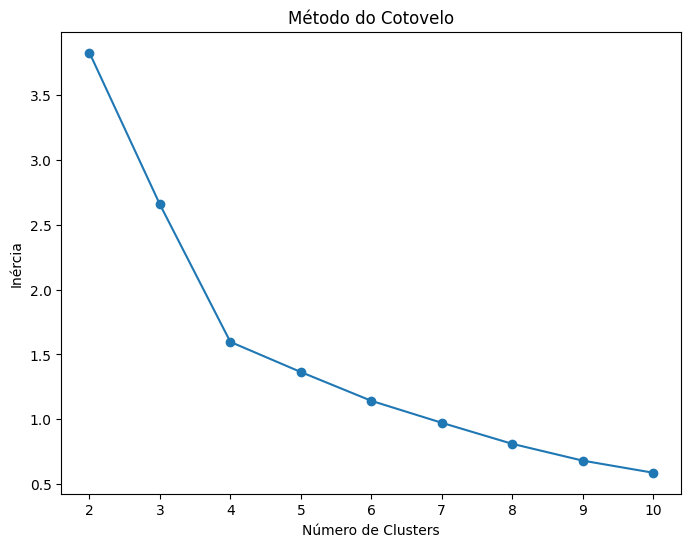

In [46]:
# Lista para armazenar os valores de inércia (soma dos quadrados das distâncias dos pontos ao centro do cluster)
inertia = []

# Teste diferentes valores de k (número de clusters)
for k in range(2, 11):
    # Crie um modelo KMeans com o número atual de clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Treine o modelo no conjunto de dados
    kmeans.fit(metrics_scaled.values)
    
    # Adicione a inércia à lista
    inertia.append(kmeans.inertia_)

# Trace o gráfico do método do cotovelo
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

#### Silhouette analysis

For n_clusters = 2 The average silhouette_score is : 0.44682943699340855
For n_clusters = 3 The average silhouette_score is : 0.3582205132563705
For n_clusters = 4 The average silhouette_score is : 0.4750015034978769
For n_clusters = 5 The average silhouette_score is : 0.4791376886733544
For n_clusters = 6 The average silhouette_score is : 0.35379589470338185
For n_clusters = 7 The average silhouette_score is : 0.36150071386121785
For n_clusters = 8 The average silhouette_score is : 0.348839339147928
For n_clusters = 9 The average silhouette_score is : 0.37114750019529286
For n_clusters = 10 The average silhouette_score is : 0.37498508750589127


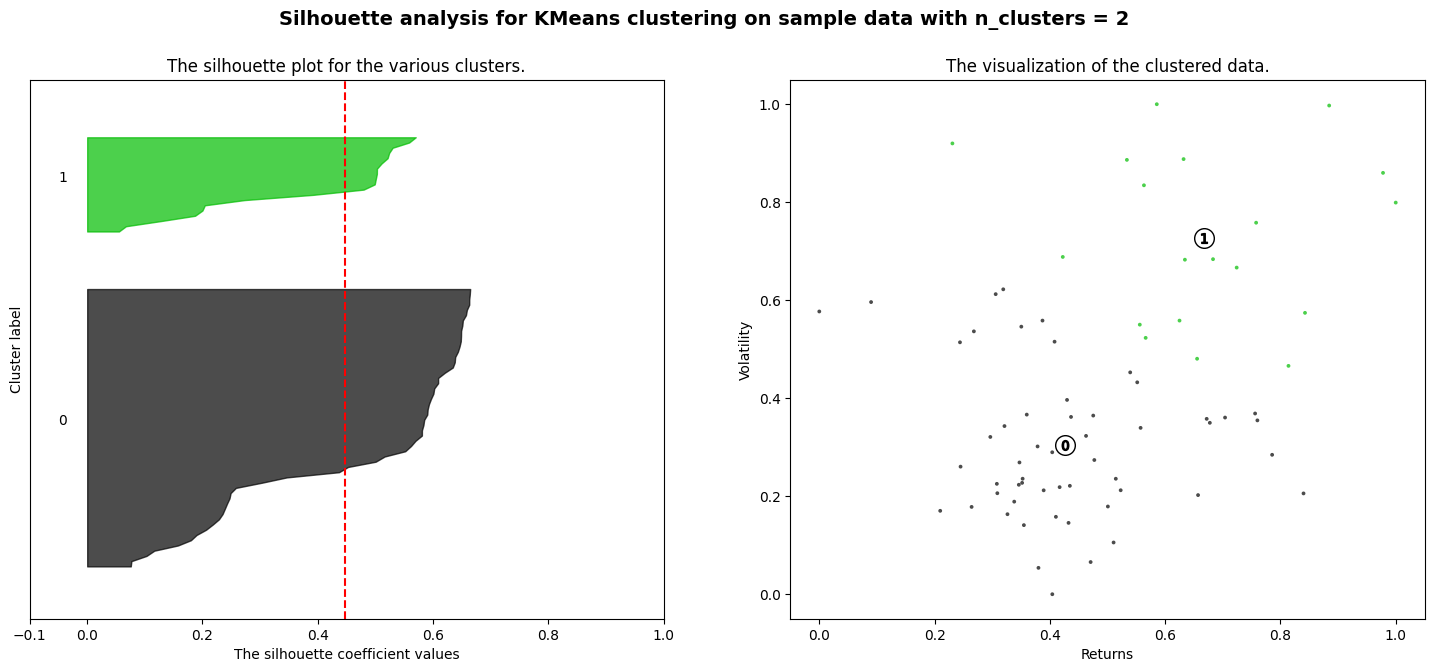

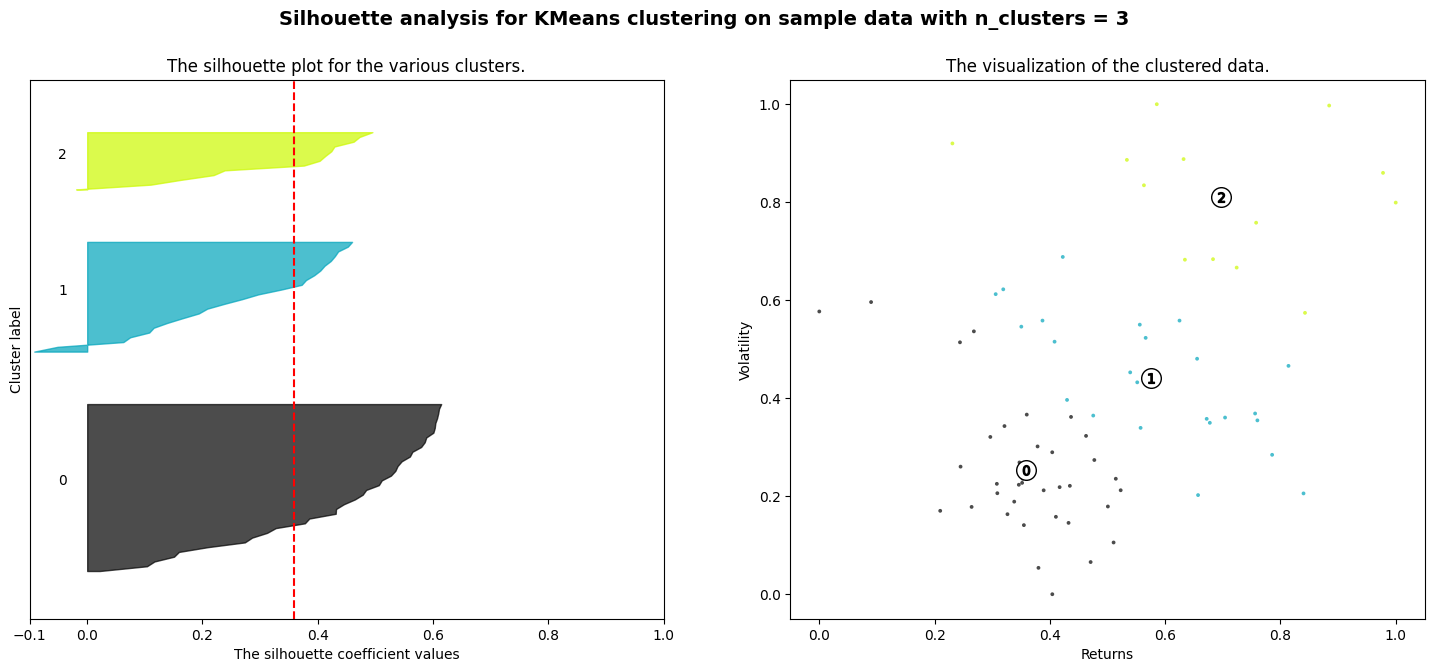

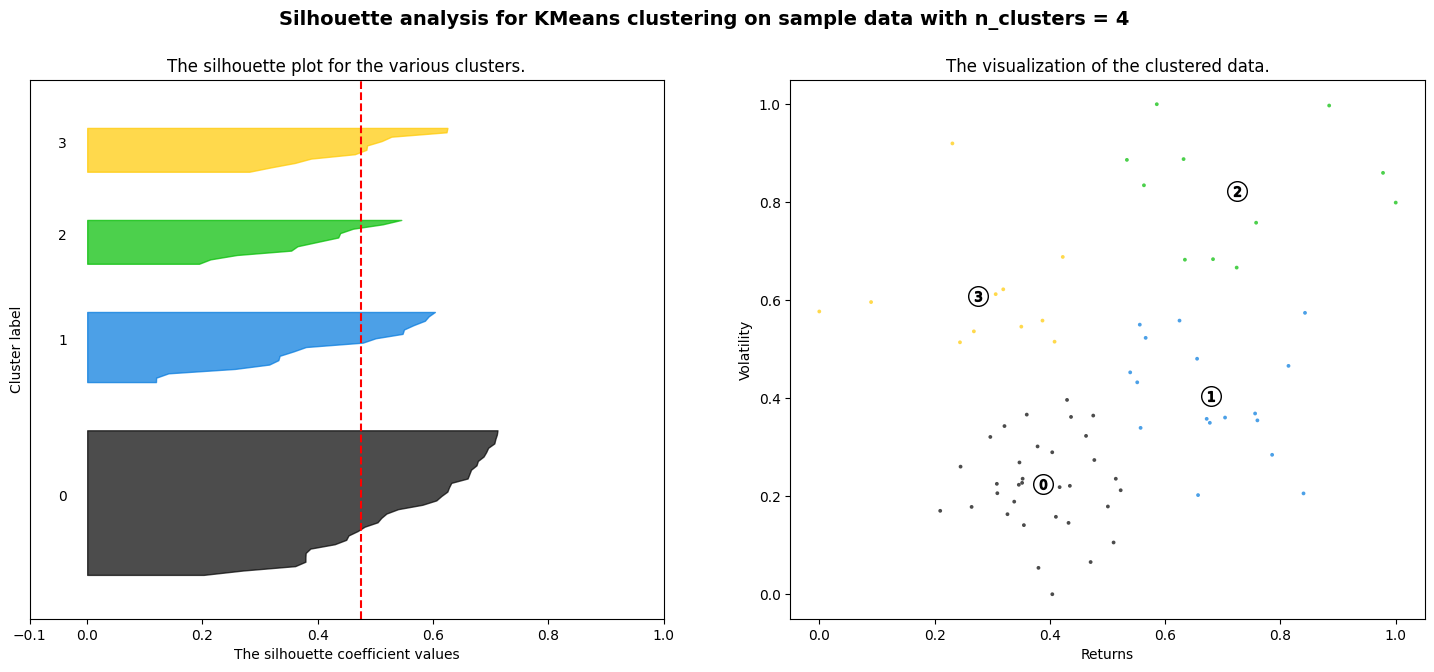

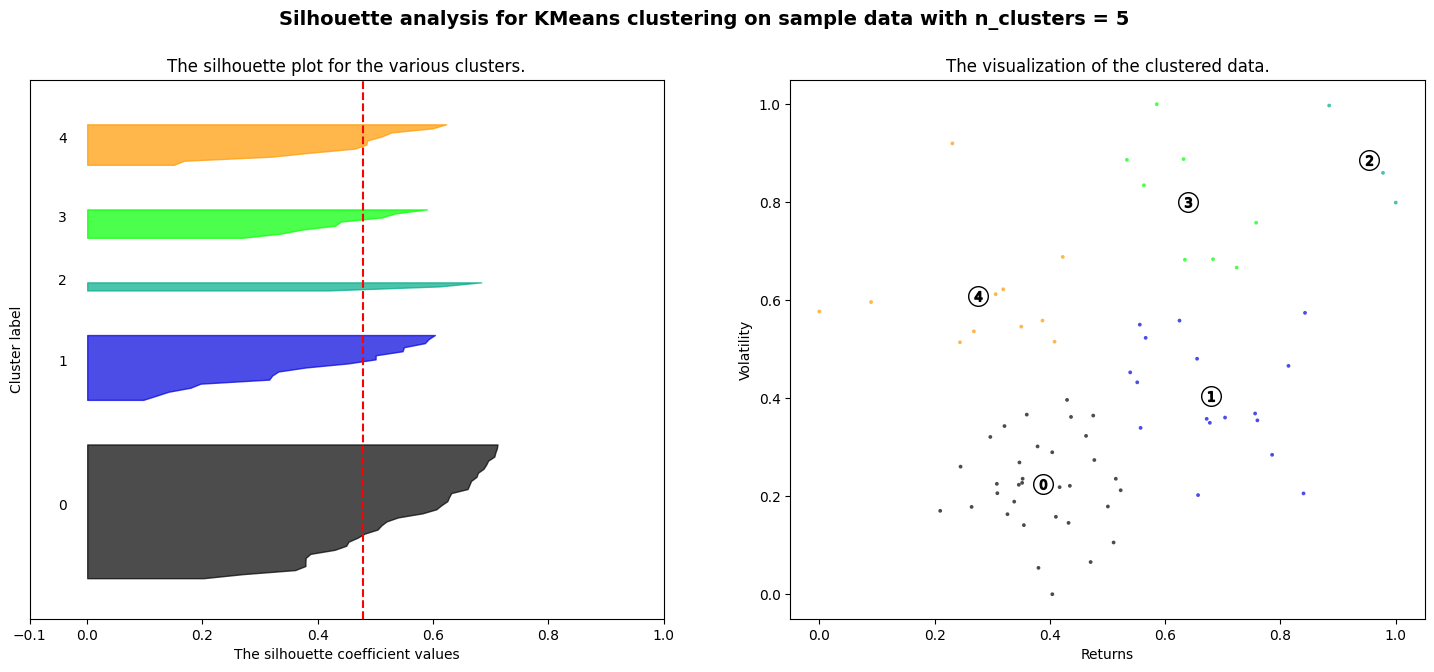

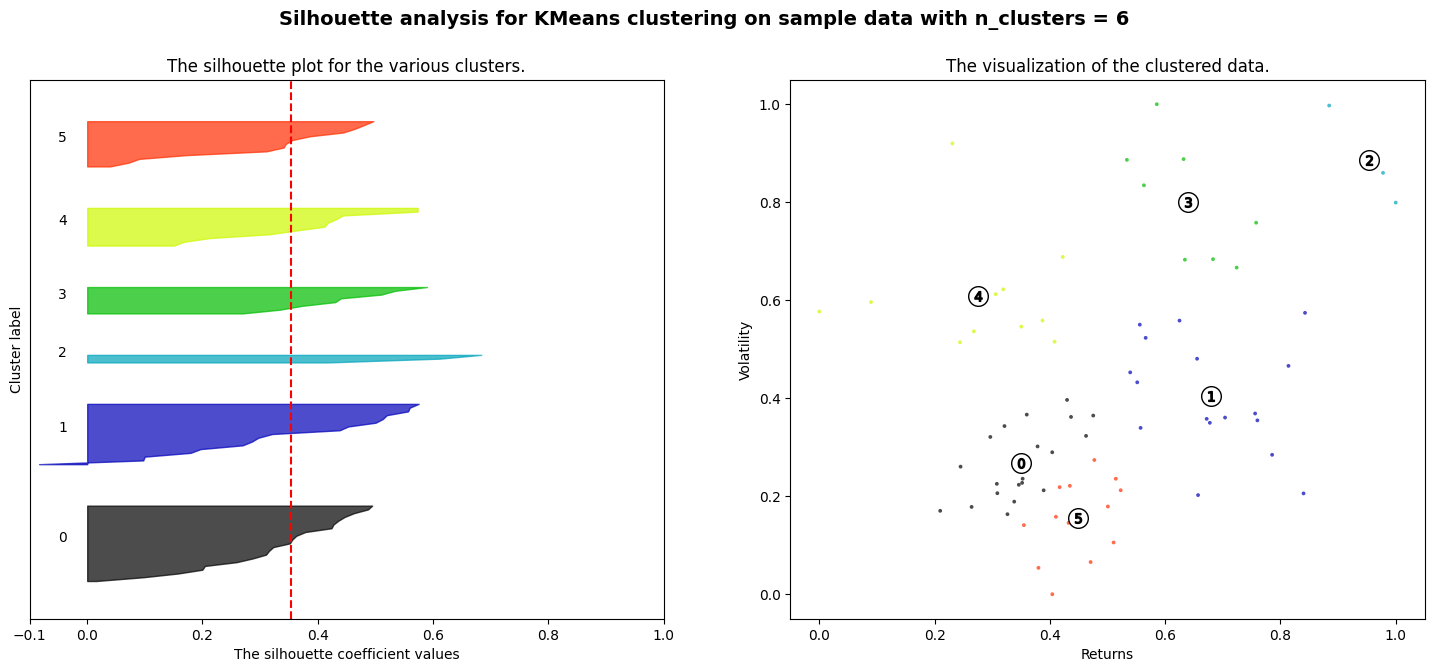

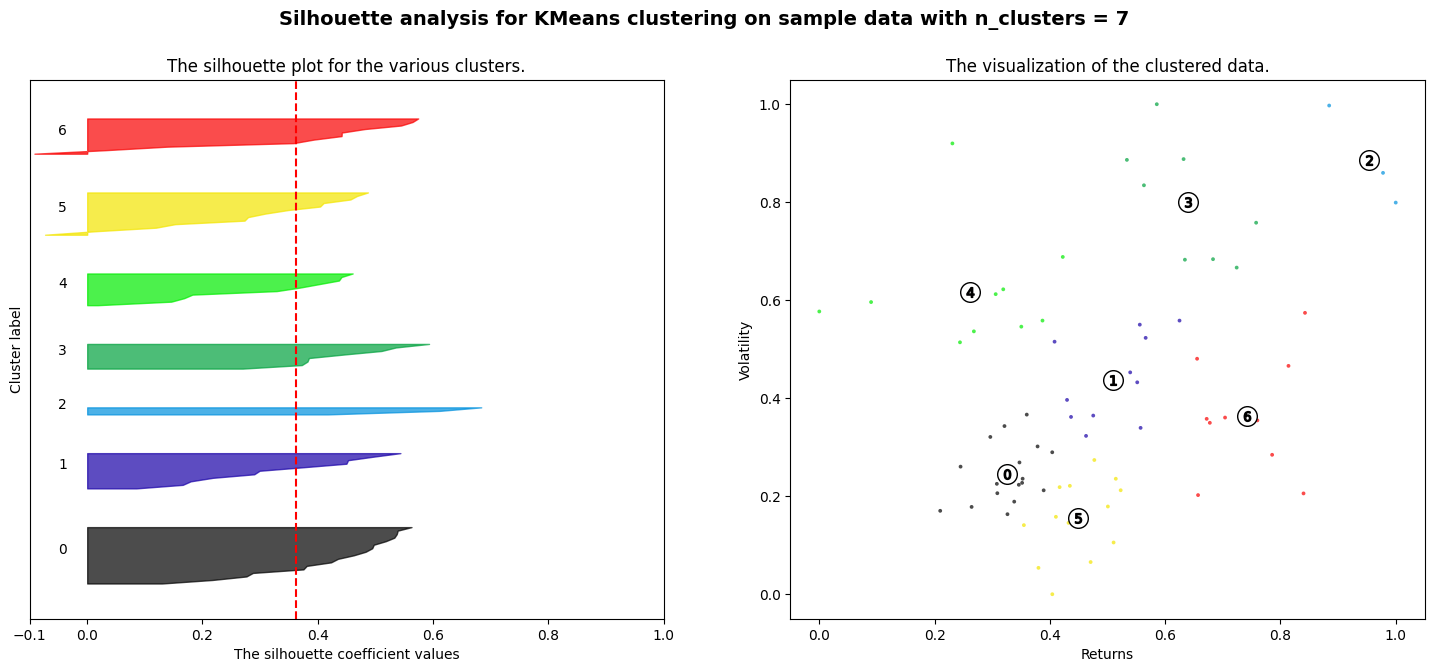

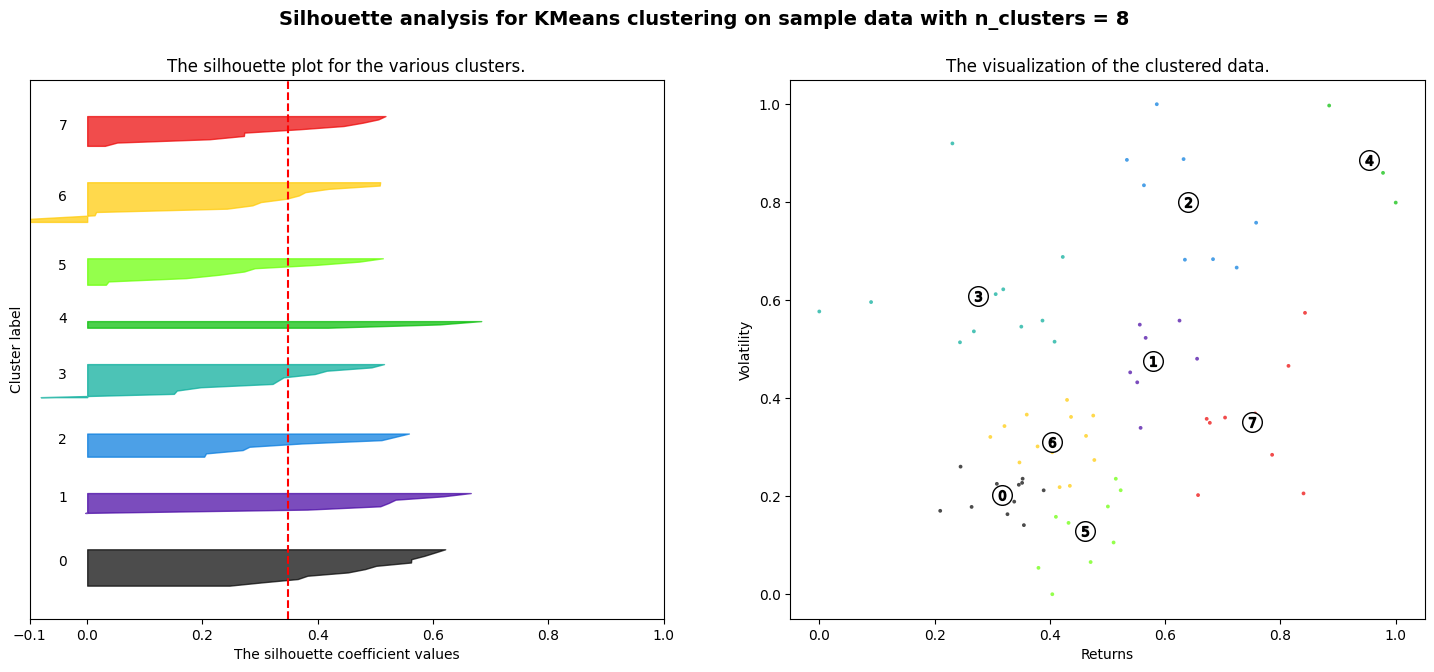

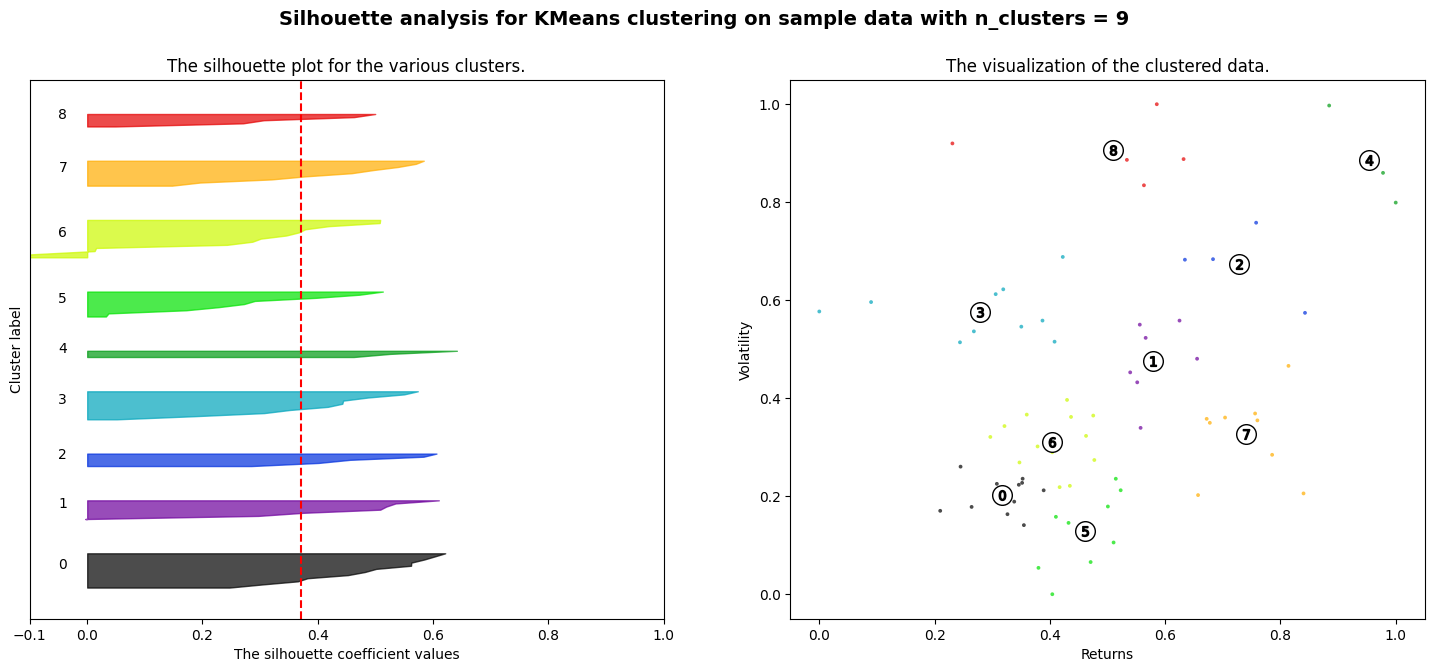

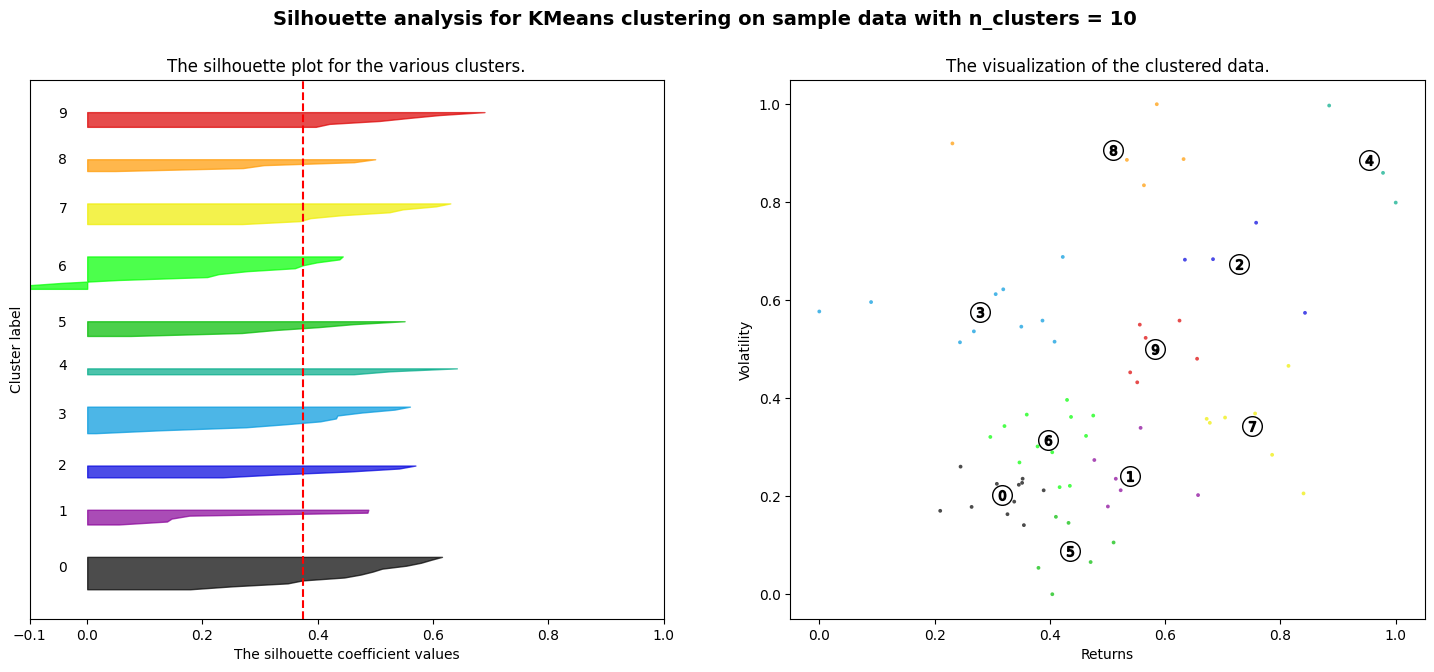

In [47]:
X = metrics_scaled.copy().values

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(metrics_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Returns")
    ax2.set_ylabel("Volatility")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### Regras de Negócio

## Results

In [32]:
# Defina os locais iniciais dos centróides
initial_centroids = np.array([[0.25, 0.25], [0.75, 0.25], [0.25,0.75], [0.75,0.75]])

# Crie o modelo KMeans com os locais iniciais especificados
kmeans = KMeans(n_clusters=4, init=initial_centroids, random_state=42, n_init=1)

# Treine o modelo
kmeans.fit(metrics_scaled)

# Obtenha os centróides finais
centroids = kmeans.cluster_centers_

# Obtenha rótulos de clusters
labels = kmeans.labels_

metrics['Cluster'] = labels

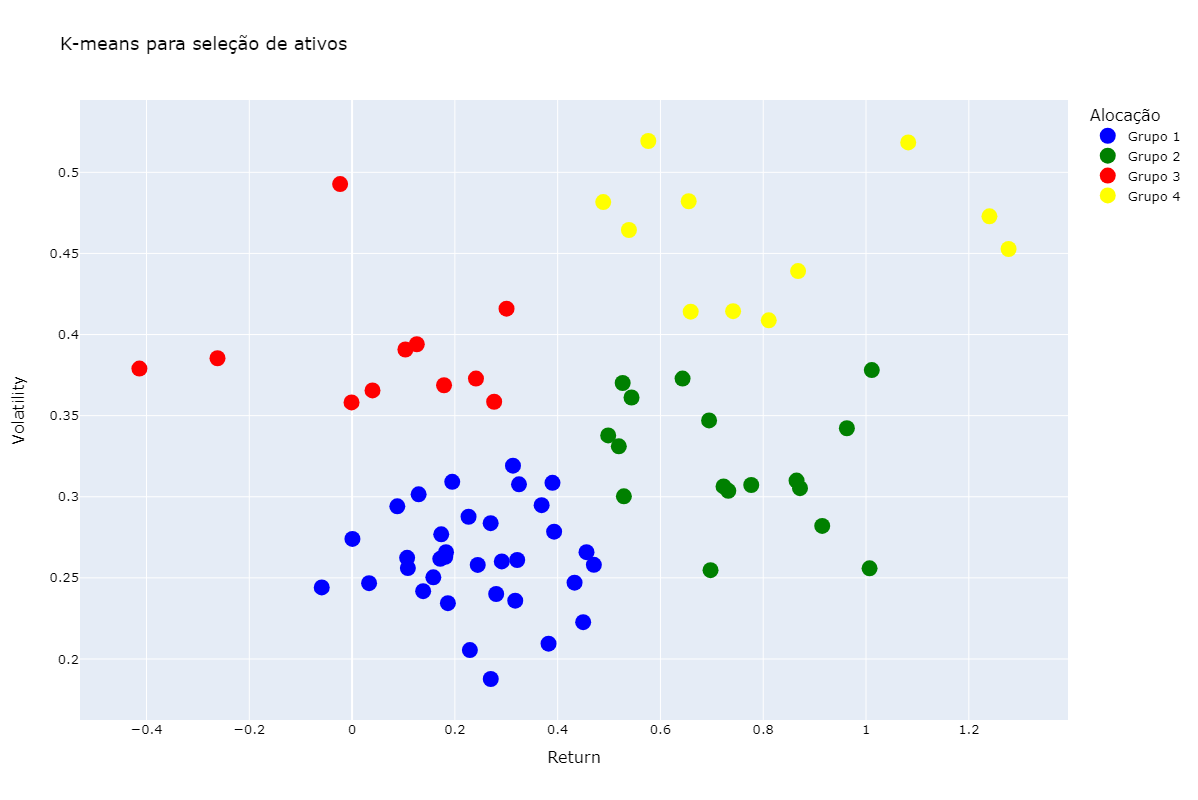

In [34]:
fig = make_subplots(rows = 1, cols = 1,
                    shared_xaxes = True,
                    vertical_spacing = 0.08)

fig.add_trace(go.Scatter(x = metrics.loc[metrics["Cluster"] == 0, "Return"]
                         , y = metrics.loc[metrics["Cluster"] == 0, "Volatility"]
                         , name = "Grupo 1", mode = "markers"
                         , text = metrics.loc[metrics["Cluster"] == 0].index
                         , marker = dict(size = 16, color = "blue"))
              , row = 1, col = 1)

fig.add_trace(go.Scatter(x = metrics.loc[metrics["Cluster"] == 1, "Return"]
                         , y = metrics.loc[metrics["Cluster"] == 1, "Volatility"]
                         , name = "Grupo 2", mode = "markers"
                         , text = metrics.loc[metrics["Cluster"] == 1].index
                         , marker = dict(size = 16, color = "green"))
              , row = 1, col = 1)

fig.add_trace(go.Scatter(x = metrics.loc[metrics["Cluster"] == 2, "Return"]
                         , y = metrics.loc[metrics["Cluster"] == 2, "Volatility"]
                         , name = "Grupo 3", mode = "markers"
                         , text = metrics.loc[metrics["Cluster"] == 2].index
                         , marker = dict(size = 16, color = "red"))
              , row = 1, col = 1)

fig.add_trace(go.Scatter(x = metrics.loc[metrics["Cluster"] == 3, "Return"]
                         , y = metrics.loc[metrics["Cluster"] == 3, "Volatility"]
                         , name = "Grupo 4", mode = "markers"
                         , text = metrics.loc[metrics["Cluster"] == 3].index
                         , marker = dict(size = 16, color = "yellow"))
              , row = 1, col = 1)

# fig.add_trace(go.Scatter(x = metrics.loc[metrics["Cluster"] == 4, "Return"]
#                          , y = metrics.loc[metrics["Cluster"] == 4, "Volatility"]
#                          , name = "Grupo 5", mode = "markers"
#                          , text = metrics.loc[metrics["Cluster"] == 4].index
#                          , marker = dict(size = 16, color = "darkgreen"))
#               , row = 1, col = 1)


fig.update_layout(height = 400, width = 600
                  , title_text = "K-means para seleção de ativos"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Return"
                  , yaxis_title = "Volatility"
                  , showlegend = True
                  , legend_title = "Alocação"
                  , font = dict(size = 13, color = "Black")
                 )
fig.update_layout(hovermode = "closest", 
                  height=800, width=800)

fig.show()

## References

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

https://www.youtube.com/watch?v=VP7kEUuswgg

https://www.youtube.com/watch?v=DzM8dHGiuZM

https://www.youtube.com/watch?v=jrixplyYy84

## Draft

In [17]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Gere dados de exemplo
np.random.seed(42)
X = metrics.copy().values

# Defina os locais iniciais dos centróides
initial_centroids = np.array([[-0.5, 0.5], [0.25, 0.25], [0.75,0.25], [0.25,0.75], [0.75,0.75]])

# Crie o modelo KMeans com os locais iniciais especificados
kmeans = KMeans(n_clusters=5, init=initial_centroids, random_state=42, n_init=1)

# Treine o modelo
kmeans.fit(X)

# Obtenha os centróides finais
centroids = kmeans.cluster_centers_

# Obtenha rótulos de clusters
labels = kmeans.labels_

# Plotagem dos dados e centróides
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red')
plt.title('KMeans com Locais Iniciais dos Centróides Especificados')
plt.show()

ValueError: The shape of the initial centers (5, 2) does not match the number of features of the data 3.

In [ ]:
all_b3_tickers

In [ ]:
import yfinance as yf

# Obtendo a lista de tickers do S&P 500
sp500_tickers = yf.download('ALPA4.SA', start='2022-01-01', end='2022-12-31')
sp500_tickers 

In [ ]:
import yfinance as yf

tickers = yf.Tickers('msft aapl goog')

# access each ticker using (example)
tickers.tickers['MSFT'].info
tickers.tickers['AAPL'].history(period="1mo")
tickers.tickers['GOOG'].actions

In [ ]:
tickers.history(period='1d')['Close']

In [ ]:
help(yf.download)

In [ ]:
plt.scatter(metrics['Return'],metrics['Volatility'])
plt.xlim(-1,1)
plt.ylim(0,1)